In [1]:
# Standard Imports
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Disable truncation of DataFrame display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
# ...existing code...

##### Data Collection

In [2]:
def get_klines(symbol="BTCUSDT", interval="5m", limit=1000):
    """Fetch OHLCV data from Binance."""
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    
    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    
    df = pd.DataFrame(raw, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    
    numeric_cols = ["open", "high", "low", "close", "volume", 
                    "quote_volume", "taker_buy_base", "taker_buy_quote"]
    df[numeric_cols] = df[numeric_cols].astype(float)
    
    return df.drop('ignore', axis=1)


def get_funding_rates(symbol="BTCUSDT", limit=1000):
    """Fetch historical funding rates from Binance Futures."""
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    params = {"symbol": symbol, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    df = pd.DataFrame(raw)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms")
    df["fundingRate"] = df["fundingRate"].astype(float)
    
    return df[["fundingTime", "fundingRate"]]

##### Feature generation

In [3]:
# ============================================================================
# CVD FEATURES
# ============================================================================

def calculate_cvd_features(df):
    """Calculate CVD approximation and related features."""
    df = df.copy()
    
    # CVD approximation
    df['buy_volume'] = df['taker_buy_base']
    df['sell_volume'] = df['volume'] - df['taker_buy_base']
    df['volume_delta'] = df['buy_volume'] - df['sell_volume']
    df['cvd'] = df['volume_delta'].cumsum()
    df['buy_sell_ratio'] = df['buy_volume'] / df['sell_volume'].replace(0, 1)
    
    # Rolling CVD features
    for window in [5, 10, 20]:
        df[f'cvd_slope_{window}'] = df['cvd'].diff(window) / window
        df[f'avg_volume_delta_{window}'] = df['volume_delta'].rolling(window).mean()
        df[f'avg_buy_sell_ratio_{window}'] = df['buy_sell_ratio'].rolling(window).mean()
    
    return df

# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

def calculate_technical_features(df):
    """Calculate technical indicators: volatility, momentum, trend."""
    df = df.copy()
    
    # === Returns ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # === Volatility ===
    # ATR (Average True Range)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = np.abs(df['high'] - df['close'].shift(1))
    df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
    df['true_range'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr_14'] = df['true_range'].rolling(14).mean()
    df['atr_20'] = df['true_range'].rolling(20).mean()
    
    # Realized volatility
    df['realized_vol_20'] = df['returns'].rolling(20).std()
    
    # Volatility regime (percentile-based)
    df['vol_percentile'] = df['atr_20'].rolling(100).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    # === Moving Averages ===
    for period in [10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    
    # Distance from MAs
    df['price_to_sma_20'] = df['close'] / df['sma_20']
    df['price_to_sma_50'] = df['close'] / df['sma_50']
    
    # === RSI ===
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # === MACD ===
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    
    # === ADX (Average Directional Index) for trend strength ===
    # Calculate +DM and -DM
    high_diff = df['high'].diff()
    low_diff = -df['low'].diff()
    
    plus_dm = high_diff.where((high_diff > low_diff) & (high_diff > 0), 0)
    minus_dm = low_diff.where((low_diff > high_diff) & (low_diff > 0), 0)
    
    # Smooth with EMA
    atr_14 = df['atr_14']
    plus_di = 100 * (plus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    minus_di = 100 * (minus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    
    # Calculate DX and ADX
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    df['adx_14'] = dx.ewm(span=14, adjust=False).mean()
    df['plus_di'] = plus_di
    df['minus_di'] = minus_di
    
    # === Momentum ===
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'] - df['close'].shift(period)
        df[f'roc_{period}'] = df['close'].pct_change(period) * 100
    
    # === Volume ===
    df['volume_ma_20'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_20']
    df['volume_std_20'] = df['volume'].rolling(20).std()
    
    # Clean up intermediate columns
    df = df.drop(['high_low', 'high_close', 'low_close', 'true_range'], axis=1)
    
    return df


# ============================================================================
# REGIME FEATURES
# ============================================================================

def calculate_regime_features(df):
    """Calculate regime-based features: trend, volatility regime."""
    df = df.copy()
    
    # === Trend Regime (based on SMA relationship) ===
    # 1 = bullish, 0 = neutral, -1 = bearish
    df['trend_regime'] = 0
    df.loc[df['sma_20'] > df['sma_50'], 'trend_regime'] = 1
    df.loc[df['sma_20'] < df['sma_50'], 'trend_regime'] = -1
    
    # === Trend Alignment (multiple timeframes agree) ===
    df['trend_alignment'] = (
        (df['sma_10'] > df['sma_20']) & 
        (df['sma_20'] > df['sma_50']) & 
        (df['close'] > df['sma_10'])
    ).astype(int)
    
    # === Volatility Regime ===
    # Low/Medium/High based on percentile
    df['volatility_regime'] = pd.cut(
        df['vol_percentile'], 
        bins=[0, 0.33, 0.67, 1.0], 
        labels=['low', 'medium', 'high']
    )
    
    # === Trend Strength Regime (ADX-based) ===
    # Strong trend > 25, weak trend < 20
    df['trend_strength_regime'] = 'ranging'
    df.loc[df['adx_14'] > 25, 'trend_strength_regime'] = 'trending'
    df.loc[df['adx_14'] < 20, 'trend_strength_regime'] = 'weak'
    
    # === Momentum Persistence ===
    # Count consecutive bars with positive returns
    df['positive_returns'] = (df['returns'] > 0).astype(int)
    df['consecutive_up'] = df['positive_returns'].groupby(
        (df['positive_returns'] != df['positive_returns'].shift()).cumsum()
    ).cumsum()
    
    # Same for negative
    df['negative_returns'] = (df['returns'] < 0).astype(int)
    df['consecutive_down'] = df['negative_returns'].groupby(
        (df['negative_returns'] != df['negative_returns'].shift()).cumsum()
    ).cumsum()
    
    # Clean up
    df = df.drop(['positive_returns', 'negative_returns'], axis=1)
    
    return df


# ============================================================================
# TRIPLE BARRIER LABELING
# ============================================================================

def add_triple_barrier_labels(df, profit_pct=0.015, stop_pct=0.01, time_bars=20):
    """Add triple barrier labels to DataFrame."""
    df = df.copy()
    
    # Initialize columns
    df['label'] = np.nan
    df['barrier_hit'] = None
    df['return'] = np.nan
    df['bars_held'] = np.nan
    
    max_idx = len(df) - time_bars - 1
    
    for i in range(max_idx):
        entry_price = df['close'].iloc[i]
        upper_barrier = entry_price * (1 + profit_pct)
        lower_barrier = entry_price * (1 - stop_pct)
        
        barrier_hit = None
        bars_held = 0
        exit_price = entry_price
        
        for j in range(i + 1, min(i + time_bars + 1, len(df))):
            bars_held = j - i
            
            if df['high'].iloc[j] >= upper_barrier:
                barrier_hit = 'upper'
                exit_price = upper_barrier
                break
            
            if df['low'].iloc[j] <= lower_barrier:
                barrier_hit = 'lower'
                exit_price = lower_barrier
                break
        
        if barrier_hit is None:
            barrier_hit = 'time'
            exit_idx = min(i + time_bars, len(df) - 1)
            exit_price = df['close'].iloc[exit_idx]
            bars_held = exit_idx - i
        
        label = 1 if barrier_hit == 'upper' else (-1 if barrier_hit == 'lower' else 0)
        ret = (exit_price - entry_price) / entry_price
        
        df.iloc[i, df.columns.get_loc('label')] = label
        df.iloc[i, df.columns.get_loc('barrier_hit')] = barrier_hit
        df.iloc[i, df.columns.get_loc('return')] = ret
        df.iloc[i, df.columns.get_loc('bars_held')] = bars_held
    
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    df['bars_held'] = df['bars_held'].astype(int)
    
    return df


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def create_full_features_dataset(symbol="BTCUSDT", interval="5m", limit=1000,
                                profit_pct=0.015, stop_pct=0.01, time_bars=20):
    """
    Complete pipeline: fetch data, calculate all features, add labels.
    
    Returns:
        DataFrame with OHLCV, CVD, technical indicators, regimes, and labels.
    """
    print(f"Fetching {symbol} {interval} data...")
    klines_df = get_klines(symbol, interval, limit)
    
    print("Fetching funding rates...")
    funding_df = get_funding_rates(symbol, limit)
    
    print("Calculating CVD features...")
    df = calculate_cvd_features(klines_df)
    
    print("Calculating technical indicators...")
    df = calculate_technical_features(df)
    
    print("Calculating regime features...")
    df = calculate_regime_features(df)
    
    print("Merging funding rates...")
    df = pd.merge_asof(
        df.sort_values("close_time"),
        funding_df.sort_values("fundingTime"),
        left_on="close_time",
        right_on="fundingTime",
        direction="backward"
    )
    
    print("Generating triple barrier labels...")
    df = add_triple_barrier_labels(df, profit_pct, stop_pct, time_bars)
    
    print(f"\nDataset created: {len(df)} rows, {len(df.columns)} columns")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts().sort_index())
    
    return df

In [4]:
# ============================================================================
# EXECUTE FULL DATASET PIPELINE
# ============================================================================

# params
symbol = "BTCUSDT"
interval = "1h"
limit = 1000
profit_pct = 0.015  # 0.5% profit target
stop_pct = 0.01     # 1% stop loss
time_bars = 20      # interval x time_bars minutes max hold (ie, 5 x  20 = 100 minutes/ 1hour 40minutes)

# Create full dataset
df = create_full_features_dataset(
    symbol=symbol,
    interval=interval,
    limit=limit,
    profit_pct=profit_pct, 
    stop_pct=stop_pct,     
    time_bars=time_bars       
)

# Display info
print("\nDataset columns:")
print(df.columns.tolist())


Fetching BTCUSDT 1h data...
Fetching funding rates...
Calculating CVD features...
Calculating technical indicators...
Calculating regime features...
Merging funding rates...
Generating triple barrier labels...

Dataset created: 979 rows, 69 columns

Label distribution:
label
-1    588
 0    117
 1    274
Name: count, dtype: int64

Dataset columns:
['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'buy_volume', 'sell_volume', 'volume_delta', 'cvd', 'buy_sell_ratio', 'cvd_slope_5', 'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10', 'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20', 'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'returns', 'log_returns', 'atr_14', 'atr_20', 'realized_vol_20', 'vol_percentile', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'price_to_sma_20', 'price_to_sma_50', 'rsi_14', 'macd', 'macd_signal', 'macd_diff', 'adx_14',

##### Preprocessing

In [5]:
# Copy dataframe to avoid affecting original
df_copy = df.copy()

# Expect NaN values due to rolling calculations - largest missing based on longest rolling window
# drop rows with NaN values
df_copy = df_copy.dropna().reset_index(drop=True)

# further sample of dataframe to reduce size for modeling
sample_df = df_copy[['cvd', 'cvd_slope_5', 'cvd_slope_10',
                  'avg_buy_sell_ratio_5', 'avg_buy_sell_ratio_10',
                  'atr_14', 'adx_14', 'momentum_10', 'roc_10',
                    'trend_regime',
                    'trend_alignment', 'fundingRate','consecutive_up',
                    'consecutive_down', 'label', 'close', 'ema_10','sma_50']]

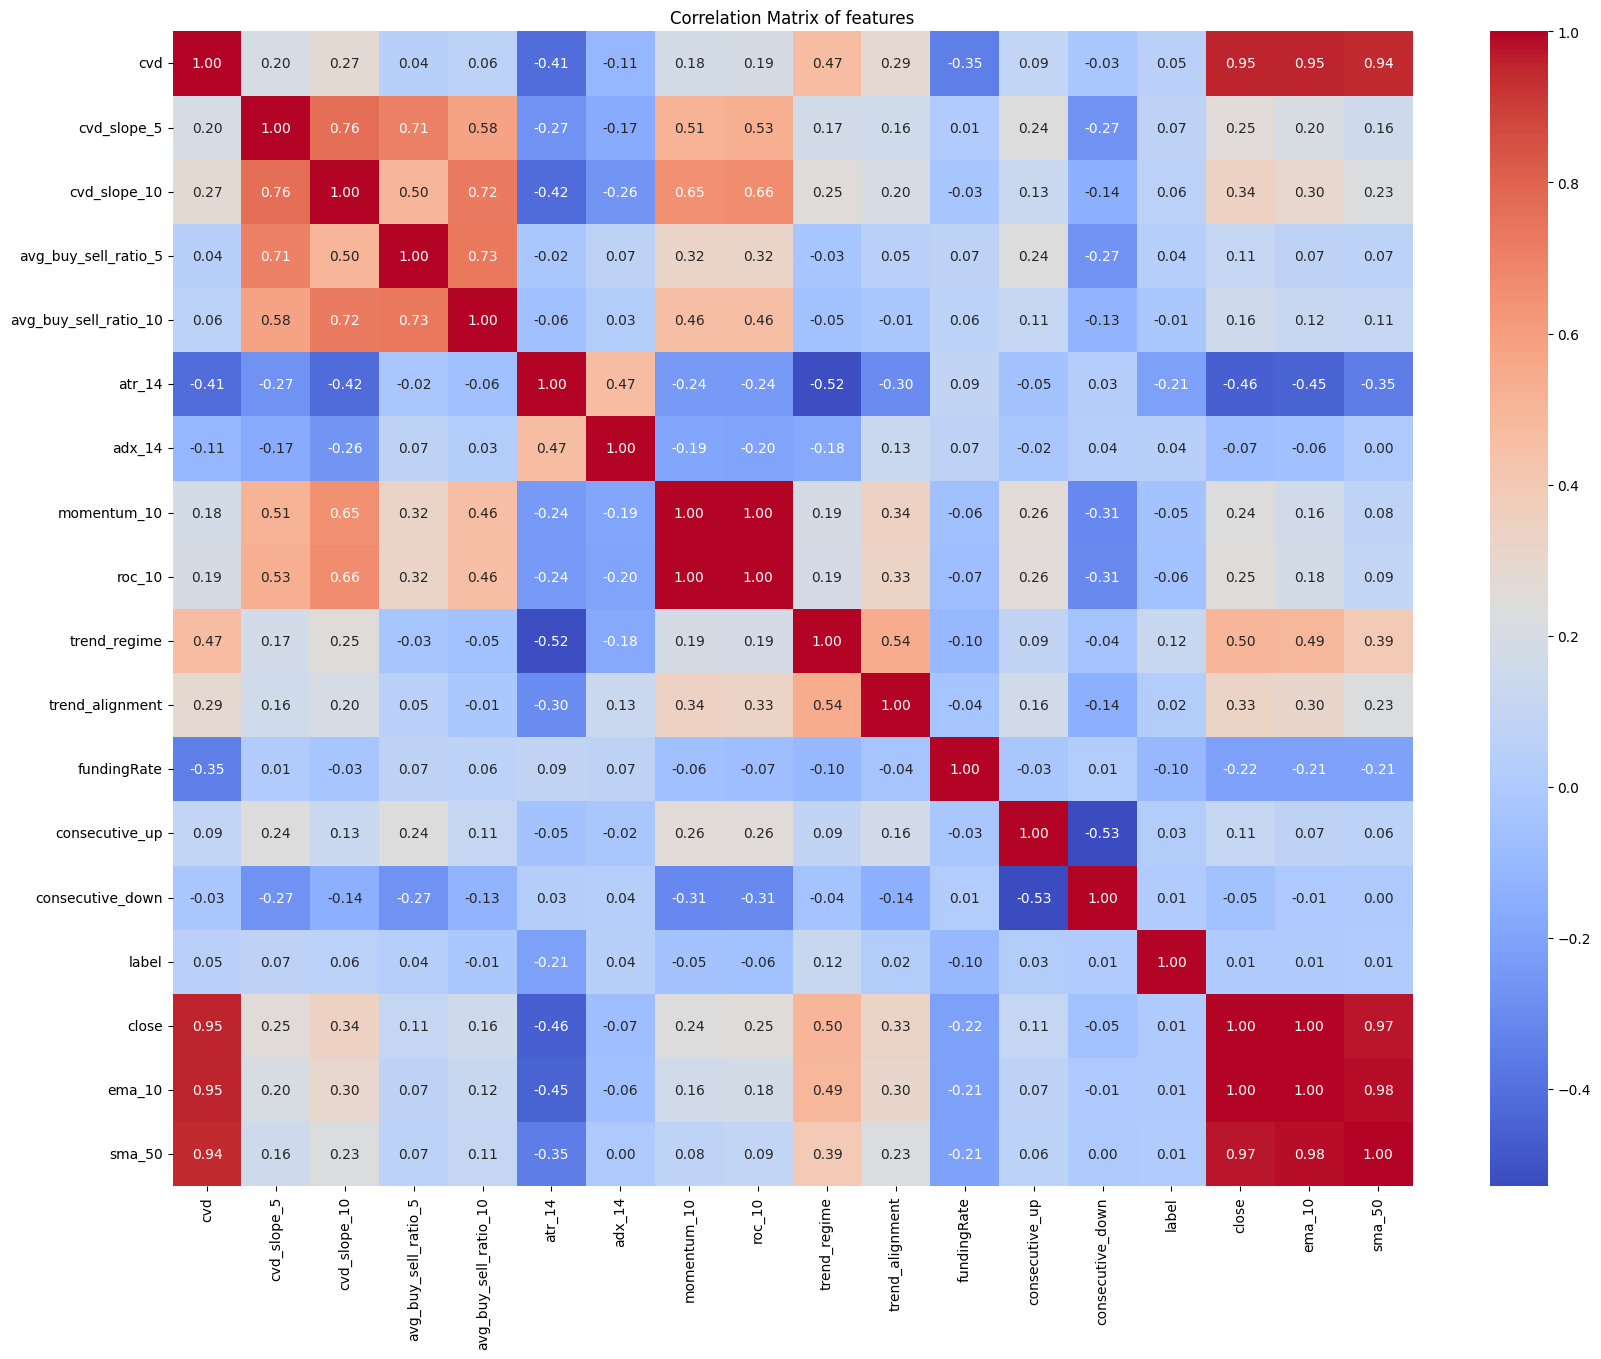

In [6]:
# correlation matrix 
corr_matrix = sample_df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of features")
plt.show()

##### Train test splits

In [7]:
# Separate features into X and y variables
X = sample_df.drop(['label'], axis=1)
y = sample_df['label']

# For time series: simple chronological split, NO shuffling
split_idx = int(len(sample_df) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# check to confirm that X_train and y_train have same datetime index
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))

True
True


In [8]:
X.columns

Index(['cvd', 'cvd_slope_5', 'cvd_slope_10', 'avg_buy_sell_ratio_5',
       'avg_buy_sell_ratio_10', 'atr_14', 'adx_14', 'momentum_10', 'roc_10',
       'trend_regime', 'trend_alignment', 'fundingRate', 'consecutive_up',
       'consecutive_down', 'close', 'ema_10', 'sma_50'],
      dtype='object')

##### Feature Scaling 

In [9]:
features_to_scale = [
    'cvd',                    # Large negative values, wide range
    'cvd_slope_5',            # Can be large positive/negative
    'cvd_slope_10',           # Can be large positive/negative
    'atr_14',                 # Absolute price values, needs scaling
    'momentum_10',            # Large range (-2211 to 3209)          # Large absolute values
    'consecutive_up',         # Counts can grow
    'consecutive_down',       # Counts can grow
    'ema_10',                 # Price based, large values
    'sma_50',                  # Price based, large values
    'close'                    # Price based, large values
]

# Features already bounded or meaningful without scaling
features_no_scale = [
    'avg_buy_sell_ratio_5',   # Ratios are already meaningful
    'avg_buy_sell_ratio_10',  # Ratios are already meaningful
    'adx_14',                 # Bounded 0-100
    'roc_10',                 # Rate of change, already % based, small range
    'trend_regime',           # Categorical (-1, 0, 1)
    'trend_alignment',        # Binary (0, 1)
    'fundingRate'             # Already small decimals (0.00001 range)
]

from sklearn.preprocessing import RobustScaler, LabelEncoder

# initialize scaler
scaler = RobustScaler()

# Fit_transform ONLY on training data for columns that need scaling - transform test data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])


In [10]:
# XGBoost and LightGBM require labels to be 0-indexed - use LabelEncoder which handles this
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
X_train_scaled.describe()

,cvd,cvd_slope_5,cvd_slope_10,avg_buy_sell_ratio_5,avg_buy_sell_ratio_10,atr_14,adx_14,momentum_10,roc_10,trend_regime,trend_alignment,fundingRate,consecutive_up,consecutive_down,close,ema_10,sma_50
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,6.880000e+02,688.000000,6.880000e+02
mean,-0.300063,-0.151789,-0.188249,0.982048,0.981219,0.062866,36.493631,-0.061268,-0.145509,-0.072674,0.183140,0.000045,-0.021802,0.924419,-1.128102e-01,-0.131537,-2.193282e-01
std,0.717737,1.235637,1.137359,0.159028,0.116483,0.745431,12.949955,0.878435,1.486350,0.998081,0.387062,0.000040,1.338422,1.290470,6.533587e-01,0.627114,6.315292e-01
min,-2.075577,-6.178658,-4.719476,0.537695,0.690191,-1.393100,11.393301,-2.802136,-4.911343,-1.000000,0.000000,-0.000064,-1.000000,0.000000,-1.766025e+00,-1.643578,-1.825080e+00
25%,-0.824938,-0.521004,-0.551950,0.874876,0.904883,-0.462452,25.767215,-0.536763,-0.927005,-1.000000,0.000000,0.000022,-1.000000,0.000000,-6.187424e-01,-0.662413,-8.020519e-01
50%,0.000000,0.000000,0.000000,0.967048,0.972419,0.000000,34.859996,0.000000,-0.046785,-1.000000,0.000000,0.000048,0.000000,0.000000,-9.623378e-16,0.000000,1.081661e-15
75%,0.175062,0.478996,0.448050,1.081638,1.047835,0.537548,45.564546,0.463237,0.722232,1.000000,0.000000,0.000078,0.000000,1.000000,3.812576e-01,0.337587,1.979481e-01
max,0.923406,5.107893,3.650789,1.616379,1.392194,2.222715,68.807204,3.296515,5.472985,1.000000,1.000000,0.000100,7.000000,8.000000,1.100251e+00,0.958192,8.827213e-01


##### Compare performance of multiple models witg cross-val

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, log_loss)
import time

In [13]:
# ============================================================================
# DEFINE MODELS (Using Defaults with Minimal Configuration)
# ============================================================================

models = {
    # Linear Models
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        class_weight='balanced',
        max_iter=1000  # Only to ensure convergence
    ),
    
    'Logistic (L1)': LogisticRegression(
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # Naive Bayes
    'Naive Bayes': GaussianNB(),
    
    # Nearest Neighbors (test different k values but keep other defaults)
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    
    # SVM
    'SVM (Linear)': SVC(
        kernel='linear',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ),
    
    # Tree-based Models (defaults only)
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    'Extra Trees': ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    # Boosting Models (defaults only)
    'AdaBoost': AdaBoostClassifier(
        random_state=42,
        algorithm='SAMME'
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
    ),
    
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    'LightGBM': LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
}

In [14]:
# ============================================================================
# TRAIN AND EVALUATE ALL MODELS
# ============================================================================

results = []

print("\n" + "="*80)
print("TRAINING MODELS")
print("="*80)

for model_name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"Training: {model_name}")
    print(f"{'─'*80}")
    
    try:
        # Determine which labels to use (encoded for XGBoost/LightGBM)
        if model_name in ['XGBoost', 'LightGBM']:
            y_train_use = y_train_encoded
            y_test_use = y_test_encoded
        else:
            y_train_use = y_train
            y_test_use = y_test
        
        # Time training
        start_time = time.time()
        model.fit(X_train_scaled, y_train_use)
        train_time = time.time() - start_time
        
        # Predictions
        start_time = time.time()
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        predict_time = time.time() - start_time
        
        # Decode predictions if needed (convert back to original labels)
        if model_name in ['XGBoost', 'LightGBM']:
            y_train_pred = label_encoder.inverse_transform(y_train_pred)
            y_test_pred = label_encoder.inverse_transform(y_test_pred)
        
        # Probabilities (if available)
        try:
            y_test_pred_proba = model.predict_proba(X_test_scaled)
            has_proba = True
        except:
            y_test_pred_proba = None
            has_proba = False
        
        # Calculate metrics (always use original labels for consistency)
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_test, y_test_pred)
        
        val_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # Per-class accuracy
        class_accuracies = {}
        for label in [-1, 0, 1]:
            mask = y_test == label
            if mask.sum() > 0:
                class_acc = accuracy_score(y_test[mask], y_test_pred[mask])
                class_accuracies[label] = class_acc
            else:
                class_accuracies[label] = np.nan
        
        # ROC AUC (if probabilities available)
        if has_proba:
            try:
                val_auc = roc_auc_score(y_test, y_test_pred_proba, 
                                       multi_class='ovr', average='weighted')
                val_logloss = log_loss(y_test, y_test_pred_proba)
            except:
                val_auc = np.nan
                val_logloss = np.nan
        else:
            val_auc = np.nan
            val_logloss = np.nan
        
        # Store results
        results.append({
            'Model': model_name,
            'Train_Accuracy': train_acc,
            'Val_Accuracy': val_acc,
            'Val_Precision': val_precision,
            'Val_Recall': val_recall,
            'Val_F1': val_f1,
            'Val_AUC': val_auc,
            'Val_LogLoss': val_logloss,
            'Loss_Accuracy': class_accuracies.get(-1, np.nan),
            'Time_Accuracy': class_accuracies.get(0, np.nan),
            'Profit_Accuracy': class_accuracies.get(1, np.nan),
            'Overfit_Gap': train_acc - val_acc,
            'Train_Time': train_time,
            'Predict_Time': predict_time,
            'Has_Proba': has_proba
        })
        
        print(f"✓ Training Accuracy:   {train_acc:.4f}")
        print(f"✓ Validation Accuracy: {val_acc:.4f}")
        print(f"✓ F1 Score:            {val_f1:.4f}")
        print(f"✓ Train Time:          {train_time:.2f}s")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        results.append({
            'Model': model_name,
            'Train_Accuracy': np.nan,
            'Val_Accuracy': np.nan,
            'Val_Precision': np.nan,
            'Val_Recall': np.nan,
            'Val_F1': np.nan,
            'Val_AUC': np.nan,
            'Val_LogLoss': np.nan,
            'Loss_Accuracy': np.nan,
            'Time_Accuracy': np.nan,
            'Profit_Accuracy': np.nan,
            'Overfit_Gap': np.nan,
            'Train_Time': np.nan,
            'Predict_Time': np.nan,
            'Has_Proba': False
        })


TRAINING MODELS

────────────────────────────────────────────────────────────────────────────────
Training: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.5625
✓ Validation Accuracy: 0.6994
✓ F1 Score:            0.7043
✓ Train Time:          0.09s

────────────────────────────────────────────────────────────────────────────────
Training: Logistic (L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ Training Accuracy:   0.5581
✓ Validation Accuracy: 0.6705
✓ F1 Score:            0.6785
✓ Train Time:          0.25s

────────────────────────────────────────────────────────────────────────────────
Training: Naive Bayes
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.5683
✓ Validation Accuracy: 0.6879
✓ F1 Score:            0.5607
✓ Train Time:          0.00s

────────────────────────────────────────────────────────────────────────────────
Training: KNN (k=5)
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.7544
✓ Validation Accuracy: 0.6185
✓ F1 Score:            0.5986
✓ Train Time:          0.00s

────────────────────────────────────────────────────────────────────────────────
Training: KNN (k=10)
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.7093
✓ Validation Accuracy: 0.6185
✓ F1 Score:            0.5715
✓

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


✓ Training Accuracy:   0.9942
✓ Validation Accuracy: 0.3468
✓ F1 Score:            0.3023
✓ Train Time:          0.92s

────────────────────────────────────────────────────────────────────────────────
Training: XGBoost
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✓ Training Accuracy:   1.0000
✓ Validation Accuracy: 0.6069
✓ F1 Score:            0.6118
✓ Train Time:          1.52s

────────────────────────────────────────────────────────────────────────────────
Training: LightGBM
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   1.0000
✓ Validation Accuracy: 0.6474
✓ F1 Score:            0.6468
✓ Train Time:          0.13s


In [15]:
results_df = pd.DataFrame(results)
results_df

,Model,Train_Accuracy,Val_Accuracy,Val_Precision,Val_Recall,Val_F1,Val_AUC,Val_LogLoss,Loss_Accuracy,Time_Accuracy,Profit_Accuracy,Overfit_Gap,Train_Time,Predict_Time,Has_Proba
0,Logistic Regression,0.562500,0.699422,0.712241,0.699422,0.704335,0.700429,0.672395,0.747899,0.0,0.603774,-0.136922,0.093115,0.001924,True
1,Logistic (L1),0.558140,0.670520,0.699693,0.670520,0.678452,0.686942,0.705306,0.689076,0.0,0.641509,-0.112381,0.250859,0.000000,True
2,Naive Bayes,0.568314,0.687861,0.473153,0.687861,0.560654,0.230306,3.389162,1.000000,0.0,0.000000,-0.119547,0.000000,0.000000,True
3,KNN (k=5),0.754360,0.618497,0.589585,0.618497,0.598624,0.574388,2.653763,0.789916,0.0,0.245283,0.135863,0.000000,1.851705,True
4,KNN (k=10),0.709302,0.618497,0.550414,0.618497,0.571480,0.634132,0.858886,0.840336,0.0,0.132075,0.090805,0.002005,0.038355,True
5,SVM (Linear),0.603198,0.612717,0.671833,0.612717,0.625035,0.707108,0.650576,0.596639,0.0,0.660377,-0.009519,0.371137,0.000000,True
6,Decision Tree,1.000000,0.514451,0.578608,0.514451,0.543090,0.503252,17.500965,0.638655,0.0,0.245283,0.485549,0.015738,0.000000,True
7,Random Forest,1.000000,0.676301,0.655217,0.676301,0.662773,0.660181,0.789437,0.815126,0.0,0.377358,0.323699,0.136569,0.071796,True
8,Extra Trees,1.000000,0.670520,0.626143,0.670520,0.631814,0.618920,0.713268,0.873950,0.0,0.226415,0.329480,0.113824,0.059964,True
9,AdaBoost,0.691860,0.647399,0.464099,0.647399,0.540635,0.527315,1.052831,0.941176,0.0,0.000000,0.044462,0.119642,0.015640,True


##### Model Comparison with Cross Validation


CROSS-VALIDATION MODEL COMPARISON

Using 5-fold Time Series Cross-Validation
Training set size: 688

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3930 (±0.1350)
✓ CV F1:       0.3399
✓ Total Time:  0.31s

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ CV Accuracy: 0.4088 (±0.1399)
✓ CV F1:       0.3595
✓ Total Time:  0.64s

────────────────────────────────────────────────────────────────────────────────
CV Training: Naive Bayes
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3737 (±0.1040)
✓ CV F1:       0.3429
✓ Total Time:  0.02s

────────────────────────────────────────────────────────────────────────────────
CV Training: KNN (k=5)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4526 (±0.0788)
✓ CV F1:       0.4406
✓ Total Time:  0.00s

────────────────────────────────────────────────────────────────────────────────
CV Training: KNN (k=10)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4421 (±0.0861)
✓ CV F1:       0.4096
✓ Total Time:  0.00s

────────────────────────────────────────────────────────────────────────────────
CV Training: SVM (Linear)
───────────────────────────────

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-pack

✓ CV Accuracy: 0.3544 (±0.1461)
✓ CV F1:       0.2720
✓ Total Time:  0.42s

────────────────────────────────────────────────────────────────────────────────
CV Training: Gradient Boosting
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3193 (±0.1254)
✓ CV F1:       0.2242
✓ Total Time:  2.91s

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3649 (±0.1045)
✓ CV F1:       0.2820
✓ Total Time:  0.48s

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3526 (±0.1255)
✓ CV F1:       0.2572
✓ Total Time:  0.28s

CROSS-VALIDATION RESULTS

📊 Overall CV Performance (sorted by Mean Accuracy):
              Model  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_Precision_Mean  CV_Recall_Mean
          KNN (k=5)          0.452632         0.078772    0.440598           0.482338        0.452632
         KNN (k=10)          0.442105         0.086054    0.409568           0.462050        0.442105
      Decision Tree          0.426316         0.083144    0.389650           0.600126        0.426316
       SVM (Linear)          0.421053         0.176314    0.356392           0.411614        0.421053
      Logistic (L1)          0.408772         0.139868    0.359494          

C:\Users\User\AppData\Local\Temp\ipykernel_28156\3493735896.py:298: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(fold_data, labels=fold_labels, patch_artist=True)


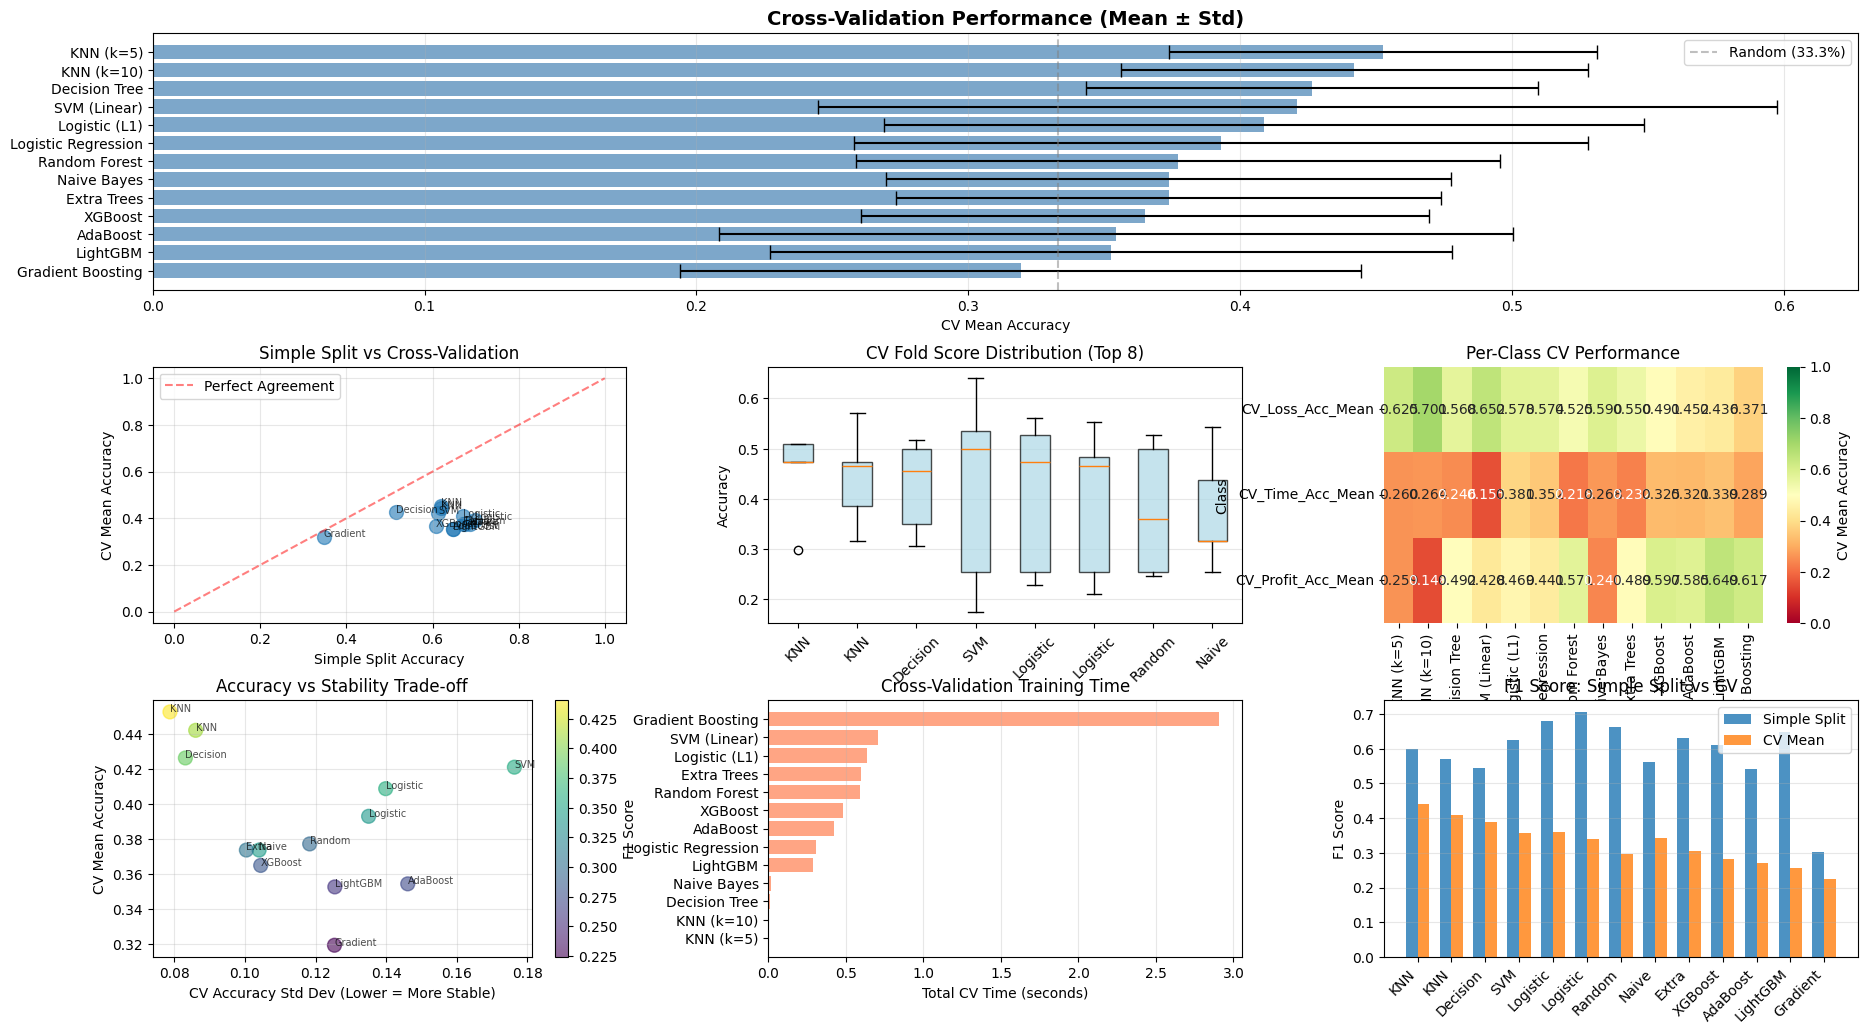


✓ CV results saved to 'cv_model_comparison_results.csv'
✓ Comparison saved to 'simple_vs_cv_comparison.csv'


In [20]:
# ============================================================================
# CROSS-VALIDATION MODEL COMPARISON
# ============================================================================

from sklearn.model_selection import TimeSeriesSplit

print("\n" + "="*80)
print("CROSS-VALIDATION MODEL COMPARISON")
print("="*80)

# Use TimeSeriesSplit for time series data (respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

cv_results = []

print("\nUsing 5-fold Time Series Cross-Validation")
print(f"Training set size: {len(X_train_scaled)}")

for model_name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"CV Training: {model_name}")
    print(f"{'─'*80}")
    
    fold_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'loss_acc': [],
        'time_acc': [],
        'profit_acc': []
    }
    fold_times = []
    
    try:
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
            # Split fold data
            X_fold_train = X_train_scaled.iloc[train_idx].copy()
            X_fold_val = X_train_scaled.iloc[val_idx].copy()
            
            # Get labels (encoded or original depending on model)
            if model_name in ['XGBoost', 'LightGBM']:
                y_fold_train = y_train_encoded[train_idx]
                y_fold_val = y_train_encoded[val_idx]
                y_fold_val_original = y_train.iloc[val_idx]
            else:
                y_fold_train = y_train.iloc[train_idx]
                y_fold_val = y_train.iloc[val_idx]
                y_fold_val_original = y_fold_val
            
            # Fit scaler on this fold's training data
            fold_scaler = RobustScaler()
            X_fold_train_scaled = X_fold_train.copy()
            X_fold_train_scaled[features_to_scale] = fold_scaler.fit_transform(
                X_fold_train[features_to_scale]
            )
            
            X_fold_val_scaled = X_fold_val.copy()
            X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
                X_fold_val[features_to_scale]
            )
            
            # Train model on this fold
            fold_start = time.time()
            
            # Clone model to avoid fitting same instance
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_fold_train_scaled, y_fold_train)
            
            fold_time = time.time() - fold_start
            fold_times.append(fold_time)
            
            # Predict
            y_fold_pred = fold_model.predict(X_fold_val_scaled)
            
            # Decode predictions if needed
            if model_name in ['XGBoost', 'LightGBM']:
                y_fold_pred = label_encoder.inverse_transform(y_fold_pred)
            
            # Calculate metrics
            fold_acc = accuracy_score(y_fold_val_original, y_fold_pred)
            fold_precision = precision_score(y_fold_val_original, y_fold_pred, 
                                            average='weighted', zero_division=0)
            fold_recall = recall_score(y_fold_val_original, y_fold_pred, 
                                       average='weighted', zero_division=0)
            fold_f1 = f1_score(y_fold_val_original, y_fold_pred, 
                              average='weighted', zero_division=0)
            
            # Store scores
            fold_scores['accuracy'].append(fold_acc)
            fold_scores['precision'].append(fold_precision)
            fold_scores['recall'].append(fold_recall)
            fold_scores['f1'].append(fold_f1)
            
            # Per-class accuracy
            for label, key in [(-1, 'loss_acc'), (0, 'time_acc'), (1, 'profit_acc')]:
                mask = y_fold_val_original == label
                if mask.sum() > 0:
                    class_acc = accuracy_score(y_fold_val_original[mask], y_fold_pred[mask])
                    fold_scores[key].append(class_acc)
                else:
                    fold_scores[key].append(np.nan)
            
            # AUC (if probabilities available)
            try:
                y_fold_proba = fold_model.predict_proba(X_fold_val_scaled)
                fold_auc = roc_auc_score(y_fold_val_original, y_fold_proba, 
                                        multi_class='ovr', average='weighted')
                fold_scores['auc'].append(fold_auc)
            except:
                fold_scores['auc'].append(np.nan)
        
        # Calculate mean and std across folds
        cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.mean(fold_scores['accuracy']),
            'CV_Accuracy_Std': np.std(fold_scores['accuracy']),
            'CV_Precision_Mean': np.mean(fold_scores['precision']),
            'CV_Recall_Mean': np.mean(fold_scores['recall']),
            'CV_F1_Mean': np.mean(fold_scores['f1']),
            'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
            'CV_Loss_Acc_Mean': np.nanmean(fold_scores['loss_acc']),
            'CV_Time_Acc_Mean': np.nanmean(fold_scores['time_acc']),
            'CV_Profit_Acc_Mean': np.nanmean(fold_scores['profit_acc']),
            'CV_Loss_Acc_Std': np.nanstd(fold_scores['loss_acc']),
            'CV_Time_Acc_Std': np.nanstd(fold_scores['time_acc']),
            'CV_Profit_Acc_Std': np.nanstd(fold_scores['profit_acc']),
            'CV_Avg_Fold_Time': np.mean(fold_times),
            'CV_Total_Time': np.sum(fold_times),
            'Fold_Scores': fold_scores['accuracy']  # Store individual fold scores
        })
        
        print(f"✓ CV Accuracy: {np.mean(fold_scores['accuracy']):.4f} (±{np.std(fold_scores['accuracy']):.4f})")
        print(f"✓ CV F1:       {np.mean(fold_scores['f1']):.4f}")
        print(f"✓ Total Time:  {np.sum(fold_times):.2f}s")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_Precision_Mean': np.nan,
            'CV_Recall_Mean': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'CV_Loss_Acc_Mean': np.nan,
            'CV_Time_Acc_Mean': np.nan,
            'CV_Profit_Acc_Mean': np.nan,
            'CV_Loss_Acc_Std': np.nan,
            'CV_Time_Acc_Std': np.nan,
            'CV_Profit_Acc_Std': np.nan,
            'CV_Avg_Fold_Time': np.nan,
            'CV_Total_Time': np.nan,
            'Fold_Scores': []
        })

# ============================================================================
# CV RESULTS DATAFRAME
# ============================================================================

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

print("\n📊 Overall CV Performance (sorted by Mean Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean', 
                'CV_Precision_Mean', 'CV_Recall_Mean']
print(cv_results_df[display_cols].to_string(index=False))

print("\n📊 Per-Class CV Accuracy:")
class_cols = ['Model', 'CV_Loss_Acc_Mean', 'CV_Time_Acc_Mean', 'CV_Profit_Acc_Mean']
print(cv_results_df[class_cols].to_string(index=False))

print("\n📊 Per-Class CV Stability (Std Dev):")
std_cols = ['Model', 'CV_Loss_Acc_Std', 'CV_Time_Acc_Std', 'CV_Profit_Acc_Std']
print(cv_results_df[std_cols].to_string(index=False))

print("\n📊 CV Training Time:")
time_cols = ['Model', 'CV_Avg_Fold_Time', 'CV_Total_Time']
print(cv_results_df[time_cols].to_string(index=False))

# ============================================================================
# COMPARE SIMPLE SPLIT VS CROSS-VALIDATION
# ============================================================================

print("\n" + "="*80)
print("SIMPLE SPLIT vs CROSS-VALIDATION COMPARISON")
print("="*80)

# Merge results
comparison_df = pd.merge(
    results_df[['Model', 'Val_Accuracy', 'Val_F1', 'Train_Time']],
    cv_results_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean', 'CV_Total_Time']],
    on='Model'
)
comparison_df['Accuracy_Diff'] = comparison_df['Val_Accuracy'] - comparison_df['CV_Accuracy_Mean']
comparison_df = comparison_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\nAccuracy Comparison:")
print(comparison_df[['Model', 'Val_Accuracy', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'Accuracy_Diff']].to_string(index=False))

print("\nF1 Score Comparison:")
print(comparison_df[['Model', 'Val_F1', 'CV_F1_Mean']].to_string(index=False))

# ============================================================================
# CV ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

best_cv_model = cv_results_df.iloc[0]['Model']
best_cv_acc = cv_results_df.iloc[0]['CV_Accuracy_Mean']
best_cv_std = cv_results_df.iloc[0]['CV_Accuracy_Std']

print(f"\n🏆 Best CV Model: {best_cv_model}")
print(f"   Mean Accuracy: {best_cv_acc:.4f} (±{best_cv_std:.4f})")
print(f"   Mean F1:       {cv_results_df.iloc[0]['CV_F1_Mean']:.4f}")

# Identify most stable models (low std)
stable_threshold = 0.05
stable_models = cv_results_df[cv_results_df['CV_Accuracy_Std'] < stable_threshold]
if len(stable_models) > 0:
    print(f"\n✓ Most Stable Models (std < {stable_threshold}):")
    for _, row in stable_models.head(3).iterrows():
        print(f"   {row['Model']}: {row['CV_Accuracy_Mean']:.4f} (±{row['CV_Accuracy_Std']:.4f})")

# Identify models with high variance across folds
unstable_threshold = 0.1
unstable_models = cv_results_df[cv_results_df['CV_Accuracy_Std'] > unstable_threshold]
if len(unstable_models) > 0:
    print(f"\n⚠️  Unstable Models (std > {unstable_threshold}):")
    for _, row in unstable_models.iterrows():
        print(f"   {row['Model']}: {row['CV_Accuracy_Mean']:.4f} (±{row['CV_Accuracy_Std']:.4f})")

# Check for overfitting (simple split much better than CV)
print("\n📊 Overfitting Check (Simple Split vs CV):")
for _, row in comparison_df.iterrows():
    if row['Accuracy_Diff'] > 0.05:
        print(f"   ⚠️  {row['Model']}: Simple={row['Val_Accuracy']:.4f}, CV={row['CV_Accuracy_Mean']:.4f}, Diff={row['Accuracy_Diff']:.4f}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(22, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. CV Mean Accuracy with Error Bars
ax1 = fig.add_subplot(gs[0, :])
cv_sorted = cv_results_df.sort_values('CV_Accuracy_Mean', ascending=True)
y_pos = np.arange(len(cv_sorted))
ax1.barh(y_pos, cv_sorted['CV_Accuracy_Mean'], xerr=cv_sorted['CV_Accuracy_Std'], 
         alpha=0.7, color='steelblue', capsize=5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(cv_sorted['Model'])
ax1.set_xlabel('CV Mean Accuracy')
ax1.set_title('Cross-Validation Performance (Mean ± Std)', fontsize=14, fontweight='bold')
ax1.axvline(0.333, color='gray', linestyle='--', alpha=0.5, label='Random (33.3%)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. Simple Split vs CV Accuracy
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(comparison_df['Val_Accuracy'], comparison_df['CV_Accuracy_Mean'], s=100, alpha=0.6)
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Agreement')
ax2.set_xlabel('Simple Split Accuracy')
ax2.set_ylabel('CV Mean Accuracy')
ax2.set_title('Simple Split vs Cross-Validation')
ax2.legend()
ax2.grid(alpha=0.3)

for _, row in comparison_df.iterrows():
    ax2.annotate(row['Model'].split()[0], 
                (row['Val_Accuracy'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.7)

# 3. CV Fold Stability (Box Plot)
ax3 = fig.add_subplot(gs[1, 1])
fold_data = []
fold_labels = []
for _, row in cv_results_df.head(8).iterrows():  # Top 8 models
    if len(row['Fold_Scores']) > 0:
        fold_data.append(row['Fold_Scores'])
        fold_labels.append(row['Model'].split()[0])

if fold_data:
    bp = ax3.boxplot(fold_data, labels=fold_labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax3.set_ylabel('Accuracy')
    ax3.set_title('CV Fold Score Distribution (Top 8)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)

# 4. Per-Class CV Performance Heatmap
ax4 = fig.add_subplot(gs[1, 2])
class_data = cv_results_df[['Model', 'CV_Loss_Acc_Mean', 'CV_Time_Acc_Mean', 
                             'CV_Profit_Acc_Mean']].set_index('Model')
sns.heatmap(class_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax4, cbar_kws={'label': 'CV Mean Accuracy'})
ax4.set_title('Per-Class CV Performance')
ax4.set_xlabel('')
ax4.set_ylabel('Class')

# 5. Accuracy vs Stability Trade-off
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(cv_results_df['CV_Accuracy_Std'], cv_results_df['CV_Accuracy_Mean'],
                     s=100, c=cv_results_df['CV_F1_Mean'], cmap='viridis', alpha=0.6)
ax5.set_xlabel('CV Accuracy Std Dev (Lower = More Stable)')
ax5.set_ylabel('CV Mean Accuracy')
ax5.set_title('Accuracy vs Stability Trade-off')
plt.colorbar(scatter, ax=ax5, label='F1 Score')
ax5.grid(alpha=0.3)

for _, row in cv_results_df.iterrows():
    ax5.annotate(row['Model'].split()[0],
                (row['CV_Accuracy_Std'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.7)

# 6. CV Training Time
ax6 = fig.add_subplot(gs[2, 1])
cv_sorted_time = cv_results_df.sort_values('CV_Total_Time', ascending=True)
ax6.barh(cv_sorted_time['Model'], cv_sorted_time['CV_Total_Time'], alpha=0.7, color='coral')
ax6.set_xlabel('Total CV Time (seconds)')
ax6.set_title('Cross-Validation Training Time')
ax6.grid(axis='x', alpha=0.3)

# 7. Simple vs CV F1 Comparison
ax7 = fig.add_subplot(gs[2, 2])
x = np.arange(len(comparison_df))
width = 0.35
ax7.bar(x - width/2, comparison_df['Val_F1'], width, label='Simple Split', alpha=0.8)
ax7.bar(x + width/2, comparison_df['CV_F1_Mean'], width, label='CV Mean', alpha=0.8)
ax7.set_ylabel('F1 Score')
ax7.set_title('F1 Score: Simple Split vs CV')
ax7.set_xticks(x)
ax7.set_xticklabels([m.split()[0] for m in comparison_df['Model']], rotation=45, ha='right')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

plt.savefig('cv_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# SAVE CV RESULTS
# ============================================================================

cv_results_df.to_csv('cv_model_comparison_results.csv', index=False)
comparison_df.to_csv('simple_vs_cv_comparison.csv', index=False)
print(f"\n✓ CV results saved to 'cv_model_comparison_results.csv'")
print(f"✓ Comparison saved to 'simple_vs_cv_comparison.csv'")

# ============================================================================
# FINAL RECOMMENDATIONS
# =========================================

In [24]:
# view results dataframe
cv_results_df = pd.read_csv('cv_model_comparison_results.csv')

# Models with best Per-Class Accuracy - You care if model correctly predicts profit targets (label=1), If Profit_Accuracy is low, model can't identify winning trades
top_profit_models = cv_results_df.sort_values('CV_Profit_Acc_Mean', ascending=False)
print("\nTop Models for Profit Class Accuracy:", top_profit_models[['Model', 'CV_Profit_Acc_Mean']].head(3))

# Models with best CV Accuracy Stability - You care about consistent performance across time, low Std Dev indicates reliability in different regimes - High std = model works in some periods, fails in others (dangerous for live trading)
stable_models = cv_results_df.sort_values('CV_Accuracy_Std')
print("\nMost Stable Models (Low Std Dev):", stable_models[['Model', 'CV_Accuracy_Std']].head(3))

# Models with Precision for Profit Class - You care about minimizing false positives when predicting profitable trades (label=1), high precision means when model predicts profit, it's usually correct
top_precision_models = cv_results_df.sort_values('CV_Precision_Mean', ascending=False)
print("\nTop Models for Precision:", top_precision_models[['Model', 'CV_Precision_Mean']].head(3))


Top Models for Profit Class Accuracy:                 Model  CV_Profit_Acc_Mean
11           LightGBM             0.64899
12  Gradient Boosting             0.61741
9             XGBoost             0.59697

Most Stable Models (Low Std Dev):            Model  CV_Accuracy_Std
0      KNN (k=5)         0.078772
2  Decision Tree         0.083144
1     KNN (k=10)         0.086054

Top Models for Precision:             Model  CV_Precision_Mean
10       AdaBoost           0.664192
2   Decision Tree           0.600126
8     Extra Trees           0.548974


##### Regularisation with cross-validation

In [17]:
# ============================================================================
# DEFINE REGULARIZED MODEL VARIANTS
# ============================================================================

regularized_models = {
    # ===== Logistic Regression - C parameter (inverse regularization) =====
    # Smaller C = stronger regularization
    'Logistic (C=0.01, L2)': LogisticRegression(
        C=0.01,  # Strong regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=0.1, L2)': LogisticRegression(
        C=0.1,  # Moderate regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=1.0, L2)': LogisticRegression(
        C=1.0,  # Default (mild regularization)
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=10.0, L2)': LogisticRegression(
        C=10.0,  # Weak regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # L1 Regularization (feature selection)
    'Logistic (C=0.1, L1)': LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=1.0, L1)': LogisticRegression(
        C=1.0,
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # ===== Decision Tree - max_depth constraint =====
    'Decision Tree (depth=3)': DecisionTreeClassifier(
        max_depth=3,  # Shallow tree, strong regularization
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=5)': DecisionTreeClassifier(
        max_depth=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=7)': DecisionTreeClassifier(
        max_depth=7,
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=10)': DecisionTreeClassifier(
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ),
    
    # ===== Random Forest - depth + sample constraints =====
    'RF (depth=5, samples=20)': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'RF (depth=10, samples=10)': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'RF (depth=None, samples=5)': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,  # No depth limit
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    # ===== XGBoost - learning rate + depth =====
    'XGBoost (lr=0.01, depth=3)': XGBClassifier(
        learning_rate=0.01,  # Slow learning, strong regularization
        max_depth=3,
        n_estimators=200,  # More trees with slower learning
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.05, depth=5)': XGBClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.1, depth=5)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.1, depth=7)': XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    # XGBoost with subsample regularization
    'XGBoost (subsample=0.6)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        subsample=0.6,  # Use 60% of data per tree
        colsample_bytree=0.6,  # Use 60% of features per tree
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (subsample=0.8)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    # ===== LightGBM - learning rate + regularization =====
    'LightGBM (lr=0.01, reg=0.1)': LGBMClassifier(
        learning_rate=0.01,
        max_depth=5,
        n_estimators=200,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=0.1,  # L2 regularization
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    'LightGBM (lr=0.05, reg=0.5)': LGBMClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    'LightGBM (lr=0.1, reg=1.0)': LGBMClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    
    # ===== Gradient Boosting - learning rate =====
    'GradBoost (lr=0.01, depth=3)': GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth=3,
        n_estimators=200,
        random_state=42
    ),
    'GradBoost (lr=0.05, depth=5)': GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        random_state=42
    ),
    'GradBoost (lr=0.1, depth=5)': GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        random_state=42
    ),
}

In [18]:
# ============================================================================
# CROSS-VALIDATION ON REGULARIZED MODELS
# ============================================================================

# Reuse TimeSeriesSplit from previous CV
reg_cv_results = []

print(f"\nTesting {len(regularized_models)} regularized model variants")
print("Using 5-fold Time Series Cross-Validation\n")

for model_name, model in regularized_models.items():
    print(f"{'─'*80}")
    print(f"CV Training: {model_name}")
    print(f"{'─'*80}")
    
    fold_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'loss_acc': [],
        'time_acc': [],
        'profit_acc': []
    }
    fold_times = []
    
    try:
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
            # Split fold data
            X_fold_train = X_train_scaled.iloc[train_idx].copy()
            X_fold_val = X_train_scaled.iloc[val_idx].copy()
            
            # Get labels (encoded or original depending on model)
            if 'XGBoost' in model_name or 'LightGBM' in model_name:
                y_fold_train = y_train_encoded[train_idx]
                y_fold_val = y_train_encoded[val_idx]
                y_fold_val_original = y_train.iloc[val_idx]
            else:
                y_fold_train = y_train.iloc[train_idx]
                y_fold_val = y_train.iloc[val_idx]
                y_fold_val_original = y_fold_val
            
            # Fit scaler on this fold's training data
            fold_scaler = RobustScaler()
            X_fold_train_scaled = X_fold_train.copy()
            X_fold_train_scaled[features_to_scale] = fold_scaler.fit_transform(
                X_fold_train[features_to_scale]
            )
            
            X_fold_val_scaled = X_fold_val.copy()
            X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
                X_fold_val[features_to_scale]
            )
            
            # Train model on this fold
            fold_start = time.time()
            
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_fold_train_scaled, y_fold_train)
            
            fold_time = time.time() - fold_start
            fold_times.append(fold_time)
            
            # Predict
            y_fold_pred = fold_model.predict(X_fold_val_scaled)
            
            # Decode predictions if needed
            if 'XGBoost' in model_name or 'LightGBM' in model_name:
                y_fold_pred = label_encoder.inverse_transform(y_fold_pred)
            
            # Calculate metrics
            fold_acc = accuracy_score(y_fold_val_original, y_fold_pred)
            fold_precision = precision_score(y_fold_val_original, y_fold_pred, 
                                            average='weighted', zero_division=0)
            fold_recall = recall_score(y_fold_val_original, y_fold_pred, 
                                       average='weighted', zero_division=0)
            fold_f1 = f1_score(y_fold_val_original, y_fold_pred, 
                              average='weighted', zero_division=0)
            
            # Store scores
            fold_scores['accuracy'].append(fold_acc)
            fold_scores['precision'].append(fold_precision)
            fold_scores['recall'].append(fold_recall)
            fold_scores['f1'].append(fold_f1)
            
            # Per-class accuracy
            for label, key in [(-1, 'loss_acc'), (0, 'time_acc'), (1, 'profit_acc')]:
                mask = y_fold_val_original == label
                if mask.sum() > 0:
                    class_acc = accuracy_score(y_fold_val_original[mask], y_fold_pred[mask])
                    fold_scores[key].append(class_acc)
                else:
                    fold_scores[key].append(np.nan)
            
            # AUC (if probabilities available)
            try:
                y_fold_proba = fold_model.predict_proba(X_fold_val_scaled)
                fold_auc = roc_auc_score(y_fold_val_original, y_fold_proba, 
                                        multi_class='ovr', average='weighted')
                fold_scores['auc'].append(fold_auc)
            except:
                fold_scores['auc'].append(np.nan)
        
        # Calculate mean and std across folds
        reg_cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.mean(fold_scores['accuracy']),
            'CV_Accuracy_Std': np.std(fold_scores['accuracy']),
            'CV_Precision_Mean': np.mean(fold_scores['precision']),
            'CV_Recall_Mean': np.mean(fold_scores['recall']),
            'CV_F1_Mean': np.mean(fold_scores['f1']),
            'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
            'CV_Loss_Acc_Mean': np.nanmean(fold_scores['loss_acc']),
            'CV_Time_Acc_Mean': np.nanmean(fold_scores['time_acc']),
            'CV_Profit_Acc_Mean': np.nanmean(fold_scores['profit_acc']),
            'CV_Loss_Acc_Std': np.nanstd(fold_scores['loss_acc']),
            'CV_Time_Acc_Std': np.nanstd(fold_scores['time_acc']),
            'CV_Profit_Acc_Std': np.nanstd(fold_scores['profit_acc']),
            'CV_Avg_Fold_Time': np.mean(fold_times),
            'CV_Total_Time': np.sum(fold_times),
            'Fold_Scores': fold_scores['accuracy']
        })
        
        print(f"✓ CV Accuracy: {np.mean(fold_scores['accuracy']):.4f} (±{np.std(fold_scores['accuracy']):.4f})")
        print(f"✓ CV F1:       {np.mean(fold_scores['f1']):.4f}\n")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}\n")
        reg_cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_Precision_Mean': np.nan,
            'CV_Recall_Mean': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'CV_Loss_Acc_Mean': np.nan,
            'CV_Time_Acc_Mean': np.nan,
            'CV_Profit_Acc_Mean': np.nan,
            'CV_Loss_Acc_Std': np.nan,
            'CV_Time_Acc_Std': np.nan,
            'CV_Profit_Acc_Std': np.nan,
            'CV_Avg_Fold_Time': np.nan,
            'CV_Total_Time': np.nan,
            'Fold_Scores': []
        })

# ============================================================================
# REGULARIZATION RESULTS DATAFRAME
# ============================================================================

reg_cv_results_df = pd.DataFrame(reg_cv_results)
reg_cv_results_df = reg_cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\n" + "="*80)
print("REGULARIZATION CV RESULTS")
print("="*80)

print("\n📊 Top 10 Regularized Models (by CV Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']
print(reg_cv_results_df[display_cols].head(10).to_string(index=False))


Testing 25 regularized model variants
Using 5-fold Time Series Cross-Validation

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.01, L2)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4351 (±0.1247)
✓ CV F1:       0.4118

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.1, L2)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4105 (±0.1429)
✓ CV F1:       0.3649

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=1.0, L2)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3930 (±0.1350)
✓ CV F1:       0.3399

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=10.0, L2)
────────────────────────────────────────────────

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

✓ CV Accuracy: 0.4000 (±0.1460)
✓ CV F1:       0.3456

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.1, L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ CV Accuracy: 0.4158 (±0.1648)
✓ CV F1:       0.3875

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=1.0, L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ CV Accuracy: 0.4088 (±0.1399)
✓ CV F1:       0.3595

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=3)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3456 (±0.1001)
✓ CV F1:       0.2821

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=5)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4175 (±0.1149)
✓ CV F1:       0.3575

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=7)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4439 (±0.0758)
✓ CV F1:       0.4047

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=10)
────────────────────────────────────────────────────────────────

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3491 (±0.0733)
✓ CV F1:       0.2953

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.05, depth=5)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3175 (±0.0636)
✓ CV F1:       0.2354

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.1, depth=5)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3439 (±0.0907)
✓ CV F1:       0.2682

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.1, depth=7)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3351 (±0.0829)
✓ CV F1:       0.2511

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (subsample=0.6)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3561 (±0.1074)
✓ CV F1:       0.2623

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (subsample=0.8)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

✓ CV Accuracy: 0.3596 (±0.1011)
✓ CV F1:       0.2663

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM (lr=0.01, reg=0.1)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3649 (±0.1188)
✓ CV F1:       0.3121

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM (lr=0.05, reg=0.5)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3491 (±0.1092)
✓ CV F1:       0.2778

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM (lr=0.1, reg=1.0)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.3632 (±0.1039)
✓ CV F1:       0.2919

────────────────────────────────────────────────────────────────────────────────
CV Training: GradBoost (lr=0.01, depth=3)
─────────────────────────────────────────────────


REGULARIZATION CV RESULTS

📊 Top 10 Regularized Models (by CV Accuracy):
                       Model  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean
     Decision Tree (depth=7)          0.443860         0.075785    0.404748
       Logistic (C=0.01, L2)          0.435088         0.124747    0.411789
     Decision Tree (depth=5)          0.417544         0.114855    0.357529
        Logistic (C=0.1, L1)          0.415789         0.164819    0.387479
    Decision Tree (depth=10)          0.412281         0.099088    0.372644
        Logistic (C=0.1, L2)          0.410526         0.142894    0.364899
        Logistic (C=1.0, L1)          0.408772         0.139868    0.359494
GradBoost (lr=0.01, depth=3)          0.408772         0.134368    0.356069
       Logistic (C=10.0, L2)          0.400000         0.146005    0.345573
        Logistic (C=1.0, L2)          0.392982         0.135031    0.339857

DEFAULT vs REGULARIZED COMPARISON

Best Performance by Model Family:
Family              

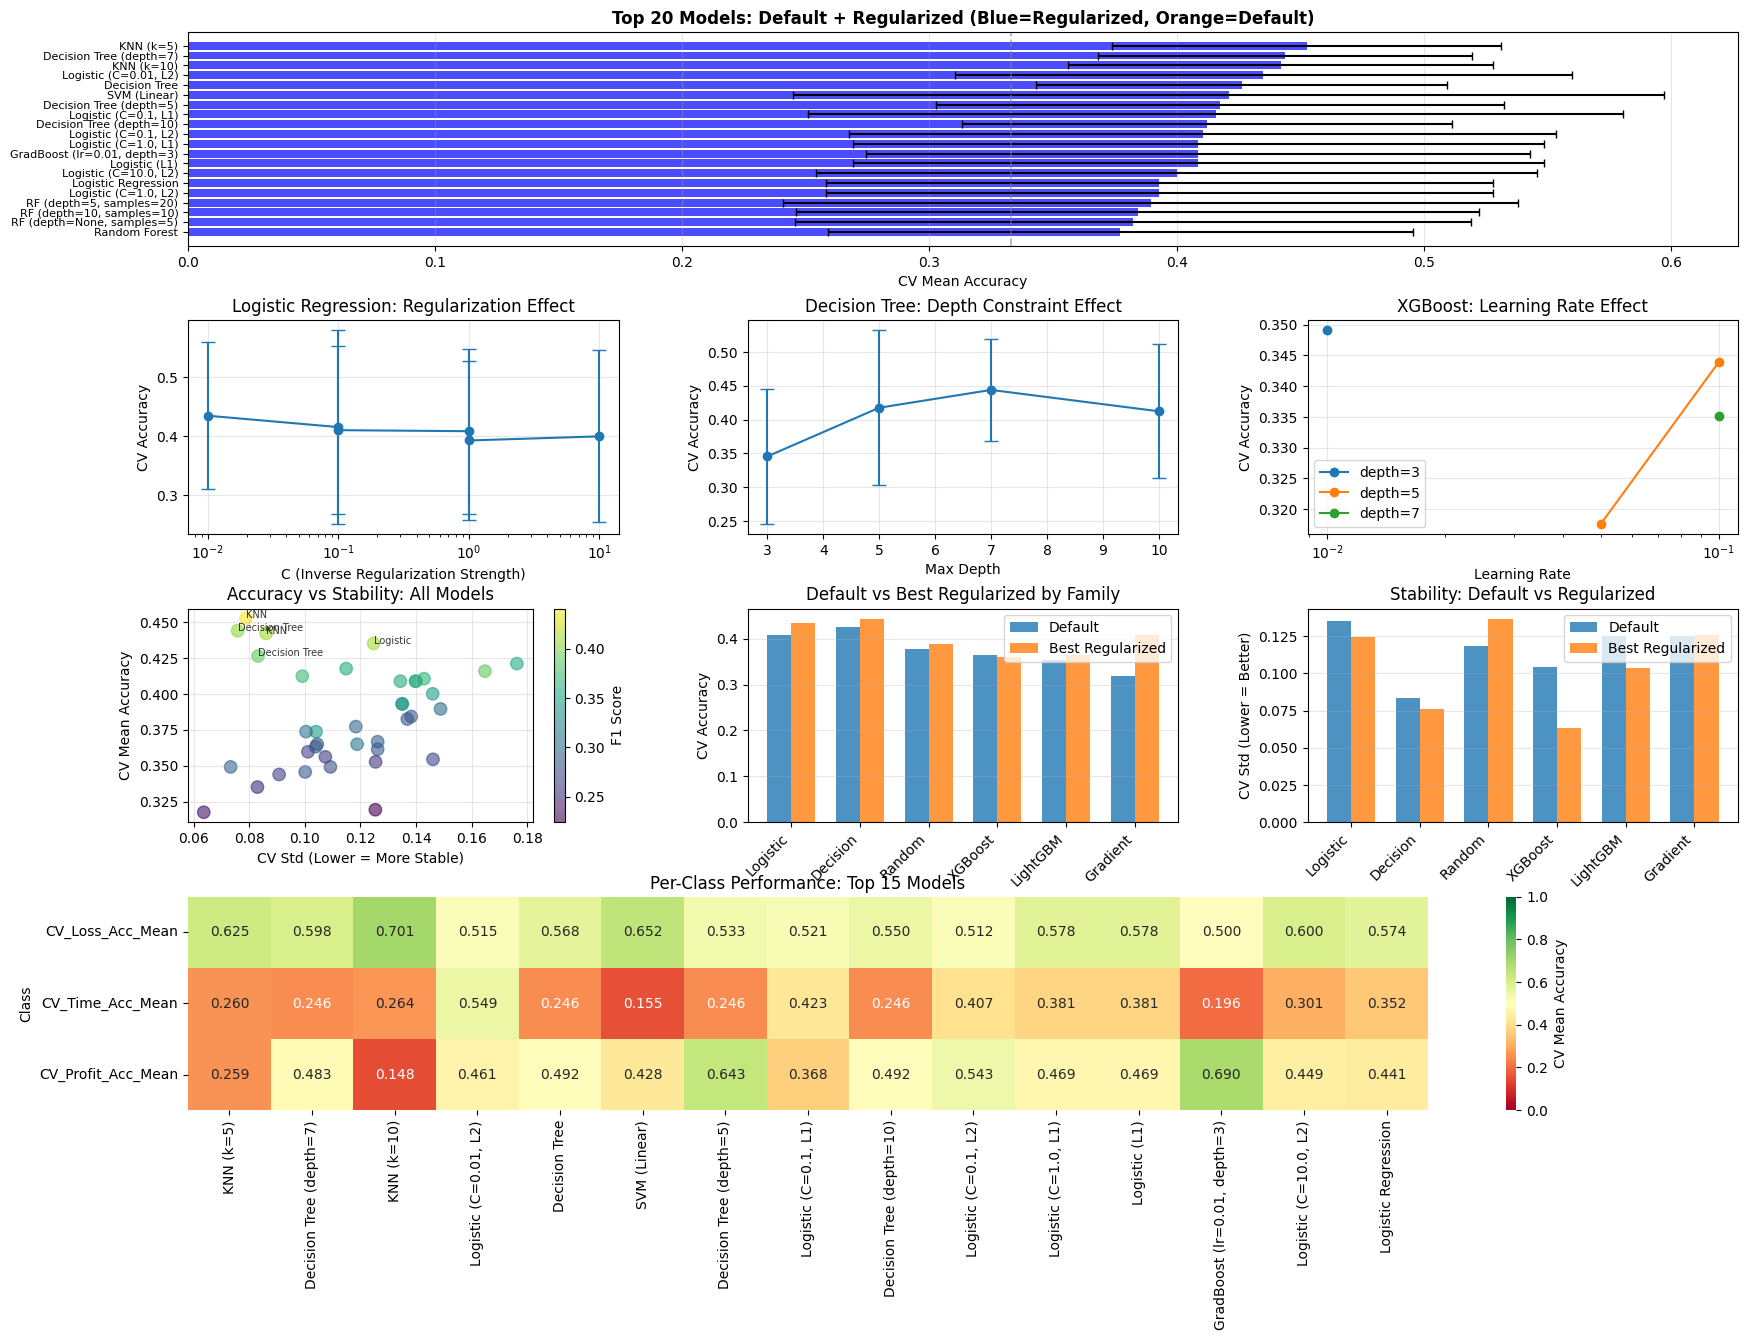

In [ ]:
# ============================================================================
# REGULARIZATION RESULTS DATAFRAME
# ============================================================================

reg_cv_results_df = pd.DataFrame(reg_cv_results)
reg_cv_results_df = reg_cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

reg_cv_results_df.to_csv('regularized_models_cv_results.csv', index=False)

print(f"\n✓ Regularized results saved to 'regularized_models_cv_results.csv'")
print(f"✓ Combined results saved to 'all_models_combined_results.csv'")

print("\n" + "="*80)
print("REGULARIZATION CV RESULTS")
print("="*80)

print("\n📊 Top 10 Regularized Models (by CV Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']
print(reg_cv_results_df[display_cols].head(10).to_string(index=False))

# ============================================================================
# COMPARE DEFAULT VS REGULARIZED
# ============================================================================

print("\n" + "="*80)
print("DEFAULT vs REGULARIZED COMPARISON")
print("="*80)

# Group by model family
def get_model_family(name):
    if 'Logistic' in name:
        return 'Logistic Regression'
    elif 'Decision Tree' in name:
        return 'Decision Tree'
    elif 'RF' in name or 'Random Forest' in name:
        return 'Random Forest'
    elif 'XGBoost' in name:
        return 'XGBoost'
    elif 'LightGBM' in name:
        return 'LightGBM'
    elif 'GradBoost' in name or 'Gradient Boosting' in name:
        return 'Gradient Boosting'
    else:
        return 'Other'

# Add family column to both dataframes
cv_results_df['Family'] = cv_results_df['Model'].apply(get_model_family)
reg_cv_results_df['Family'] = reg_cv_results_df['Model'].apply(get_model_family)

# Compare by family
print("\nBest Performance by Model Family:")
print(f"{'Family':<20} {'Best Default':<10} {'Best Regularized':<10} {'Improvement':<12}")
print("─" * 80)

for family in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
    default_best = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    reg_best = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    
    if not np.isnan(default_best) and not np.isnan(reg_best):
        improvement = reg_best - default_best
        improvement_str = f"{improvement:+.4f}"
        print(f"{family:<20} {default_best:.4f}     {reg_best:.4f}     {improvement_str}")

# ============================================================================
# REGULARIZATION ANALYSIS BY MODEL TYPE
# ============================================================================

print("\n" + "="*80)
print("REGULARIZATION IMPACT ANALYSIS")
print("="*80)

# Logistic Regression - C parameter effect
print("\n1. Logistic Regression (C parameter - inverse regularization strength):")
logistic_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'Logistic Regression'].copy()
logistic_results['C_value'] = logistic_results['Model'].str.extract(r'C=([0-9.]+)').astype(float)
logistic_results = logistic_results.sort_values('C_value')
print(logistic_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# Decision Tree - depth effect
print("\n2. Decision Tree (max_depth constraint):")
tree_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'Decision Tree'].copy()
tree_results['depth'] = tree_results['Model'].str.extract(r'depth=([0-9]+)').astype(float)
tree_results = tree_results.sort_values('depth')
print(tree_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# XGBoost - learning rate effect
print("\n3. XGBoost (learning rate + depth):")
xgb_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'XGBoost']
print(xgb_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# ============================================================================
# COMBINED COMPARISON: ALL MODELS
# ============================================================================

# Combine default and regularized results
all_models_df = pd.concat([cv_results_df, reg_cv_results_df], ignore_index=True)
all_models_df = all_models_df.sort_values('CV_Accuracy_Mean', ascending=False)
all_models_df.to_csv('all_models_combined_results.csv', index=False)


print("\n" + "="*80)
print("OVERALL BEST MODELS (Default + Regularized)")
print("="*80)

print("\n🏆 Top 15 Models Overall:")
print(all_models_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']].head(15).to_string(index=False))

# ============================================================================
# STABILITY COMPARISON
# ============================================================================

print("\n" + "="*80)
print("STABILITY COMPARISON (Lower Std = More Stable)")
print("="*80)

print("\n📊 Most Stable Models (Lowest CV Std):")
most_stable = all_models_df.nsmallest(10, 'CV_Accuracy_Std')
print(most_stable[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# Check if regularization improved stability
print("\n📊 Stability Improvement Analysis:")
for family in ['Logistic Regression', 'XGBoost', 'LightGBM']:
    default_std = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    reg_std = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    
    if not np.isnan(default_std) and not np.isnan(reg_std):
        improvement = default_std - reg_std
        if improvement > 0:
            print(f"   ✓ {family}: Regularization reduced std by {improvement:.4f}")
        else:
            print(f"   ✗ {family}: Regularization increased std by {abs(improvement):.4f}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Overall Comparison: Top 20 Models
ax1 = fig.add_subplot(gs[0, :])
top_20 = all_models_df.head(20).sort_values('CV_Accuracy_Mean', ascending=True)
colors = ['blue' if 'Default' not in str(row['Model']) else 'orange' 
          for _, row in top_20.iterrows()]
y_pos = np.arange(len(top_20))
ax1.barh(y_pos, top_20['CV_Accuracy_Mean'], xerr=top_20['CV_Accuracy_Std'],
         alpha=0.7, color=colors, capsize=3)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_20['Model'], fontsize=8)
ax1.set_xlabel('CV Mean Accuracy')
ax1.set_title('Top 20 Models: Default + Regularized (Blue=Regularized, Orange=Default)', 
              fontsize=12, fontweight='bold')
ax1.axvline(0.333, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# 2. Logistic Regression: C parameter effect
ax2 = fig.add_subplot(gs[1, 0])
logistic_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'Logistic Regression'].copy()
if len(logistic_plot) > 0:
    logistic_plot['C'] = logistic_plot['Model'].str.extract(r'C=([0-9.]+)').astype(float)
    logistic_plot = logistic_plot.dropna(subset=['C']).sort_values('C')
    
    ax2.errorbar(logistic_plot['C'], logistic_plot['CV_Accuracy_Mean'], 
                 yerr=logistic_plot['CV_Accuracy_Std'], marker='o', capsize=5)
    ax2.set_xscale('log')
    ax2.set_xlabel('C (Inverse Regularization Strength)')
    ax2.set_ylabel('CV Accuracy')
    ax2.set_title('Logistic Regression: Regularization Effect')
    ax2.grid(alpha=0.3)

# 3. Tree Depth Effect
ax3 = fig.add_subplot(gs[1, 1])
tree_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'Decision Tree'].copy()
if len(tree_plot) > 0:
    tree_plot['depth'] = tree_plot['Model'].str.extract(r'depth=([0-9]+)').astype(float)
    tree_plot = tree_plot.dropna(subset=['depth']).sort_values('depth')
    
    ax3.errorbar(tree_plot['depth'], tree_plot['CV_Accuracy_Mean'],
                 yerr=tree_plot['CV_Accuracy_Std'], marker='o', capsize=5)
    ax3.set_xlabel('Max Depth')
    ax3.set_ylabel('CV Accuracy')
    ax3.set_title('Decision Tree: Depth Constraint Effect')
    ax3.grid(alpha=0.3)

# 4. XGBoost Learning Rate Effect
ax4 = fig.add_subplot(gs[1, 2])
xgb_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'XGBoost'].copy()
if len(xgb_plot) > 0:
    xgb_plot['lr'] = xgb_plot['Model'].str.extract(r'lr=([0-9.]+)').astype(float)
    xgb_plot = xgb_plot.dropna(subset=['lr']).sort_values('lr')
    
    for depth in xgb_plot['Model'].str.extract(r'depth=([0-9]+)')[0].dropna().unique():
        depth_data = xgb_plot[xgb_plot['Model'].str.contains(f'depth={depth}')]
        ax4.plot(depth_data['lr'], depth_data['CV_Accuracy_Mean'], 
                marker='o', label=f'depth={depth}')
    
    ax4.set_xscale('log')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('CV Accuracy')
    ax4.set_title('XGBoost: Learning Rate Effect')
    ax4.legend()
    ax4.grid(alpha=0.3)

# 5. Accuracy vs Stability (All Models)
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(all_models_df['CV_Accuracy_Std'], all_models_df['CV_Accuracy_Mean'],
                     s=80, c=all_models_df['CV_F1_Mean'], cmap='viridis', alpha=0.6)
ax5.set_xlabel('CV Std (Lower = More Stable)')
ax5.set_ylabel('CV Mean Accuracy')
ax5.set_title('Accuracy vs Stability: All Models')
plt.colorbar(scatter, ax=ax5, label='F1 Score')
ax5.grid(alpha=0.3)

# Add best models annotation
best_5 = all_models_df.head(5)
for _, row in best_5.iterrows():
    ax5.annotate(row['Model'].split('(')[0][:15], 
                (row['CV_Accuracy_Std'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.8)

# 6. Default vs Best Regularized by Family
ax6 = fig.add_subplot(gs[2, 1])
families = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
default_scores = []
reg_scores = []

for family in families:
    default = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    reg = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    default_scores.append(default if not np.isnan(default) else 0)
    reg_scores.append(reg if not np.isnan(reg) else 0)

x = np.arange(len(families))
width = 0.35
ax6.bar(x - width/2, default_scores, width, label='Default', alpha=0.8)
ax6.bar(x + width/2, reg_scores, width, label='Best Regularized', alpha=0.8)
ax6.set_ylabel('CV Accuracy')
ax6.set_title('Default vs Best Regularized by Family')
ax6.set_xticks(x)
ax6.set_xticklabels([f.split()[0] for f in families], rotation=45, ha='right')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Stability by Family
ax7 = fig.add_subplot(gs[2, 2])
default_stds = []
reg_stds = []

for family in families:
    default = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    reg = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    default_stds.append(default if not np.isnan(default) else 0)
    reg_stds.append(reg if not np.isnan(reg) else 0)

ax7.bar(x - width/2, default_stds, width, label='Default', alpha=0.8)
ax7.bar(x + width/2, reg_stds, width, label='Best Regularized', alpha=0.8)
ax7.set_ylabel('CV Std (Lower = Better)')
ax7.set_title('Stability: Default vs Regularized')
ax7.set_xticks(x)
ax7.set_xticklabels([f.split()[0] for f in families], rotation=45, ha='right')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# 8. Per-Class Performance Heatmap (Top 15)
ax8 = fig.add_subplot(gs[3, :])
top_15_class = all_models_df.head(15)[['Model', 'CV_Loss_Acc_Mean', 
                                        'CV_Time_Acc_Mean', 'CV_Profit_Acc_Mean']].set_index('Model')
sns.heatmap(top_15_class.T, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, ax=ax8, cbar_kws={'label': 'CV Mean Accuracy'})
ax8.set_title('Per-Class Performance: Top 15 Models')
ax8.set_xlabel('')
ax8.set_ylabel('Class')

plt.savefig('regularization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()